In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, re, sys

# sklearn stuff
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

# keras stuff
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD

# scipy stuff
from scipy.interpolate import interp1d

%matplotlib inline

/home/m/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: TITAN X (Pascal) (0000:01:00.0)


Things to consider:

- use multiple steps instead of one per training example
- use LSTM instead of ConvNet

# Load data

In [2]:
data = pd.read_pickle('./Data/processed/full.pickle')

In [3]:
labels = np.load('./Data/processed/labels.npy')

# Split and scale data, convert to 0 indexing

In [4]:
xTr, xTe, yTr, yTe = train_test_split(data.values, labels, test_size=0.2)
ss = StandardScaler()
xTr = ss.fit_transform(xTr)
xTe = ss.transform(xTe)
yTr = np.mod(yTr, 50)
yTe = np.mod(yTe, 50)

### Convert labels to categorical

In [5]:
yTr_cat = keras.utils.to_categorical(yTr, num_classes=50)
yTe_cat = keras.utils.to_categorical(yTe, num_classes=50)

# Simple linear model

In [6]:
lr_fname = './Data/processed/lr_trained.pkl'
if os.path.isfile(lr_fname):
    lr = joblib.load(lr_fname)
else:
    lr = LogisticRegression(verbose=1, n_jobs=-1)
    lr.fit(xTr, yTr)

In [7]:
lr.score(xTe, yTe)

0.39671307920566079

In [8]:
ctr = 0
for a,b in zip(lr.predict(xTe), yTe):
    if a == b:
        print(a,b)
    else:
        print(a,b,'FAIL')
    
    ctr += 1
    if ctr > 100:
        break

27 27
46 46
4 4
18 33 FAIL
36 36
2 2
23 23
49 16 FAIL
18 2 FAIL
23 23
40 40
17 23 FAIL
2 49 FAIL
36 36
28 29 FAIL
18 28 FAIL
34 33 FAIL
29 29
18 18
7 7
18 41 FAIL
29 28 FAIL
18 33 FAIL
40 13 FAIL
18 19 FAIL
33 43 FAIL
36 36
18 19 FAIL
23 23
18 28 FAIL
10 18 FAIL
20 2 FAIL
23 24 FAIL
43 43
21 30 FAIL
23 23
18 18
6 9 FAIL
8 8
18 18
20 28 FAIL
31 26 FAIL
18 34 FAIL
7 4 FAIL
24 24
23 23
36 36
2 2
33 33
33 33
43 43
24 27 FAIL
18 36 FAIL
33 24 FAIL
23 43 FAIL
8 2 FAIL
21 28 FAIL
36 13 FAIL
18 22 FAIL
36 20 FAIL
20 20
34 34
41 40 FAIL
31 14 FAIL
26 26
41 41
23 2 FAIL
26 33 FAIL
33 33
40 40
3 3
6 31 FAIL
36 36
2 2
26 24 FAIL
23 35 FAIL
4 46 FAIL
23 23
20 18 FAIL
33 19 FAIL
33 18 FAIL
23 29 FAIL
2 29 FAIL
10 20 FAIL
30 23 FAIL
23 23
33 7 FAIL
23 28 FAIL
3 2 FAIL
40 40
28 23 FAIL
10 19 FAIL
40 40
30 30
4 4
18 18
16 16
18 18
18 48 FAIL
31 24 FAIL
23 23


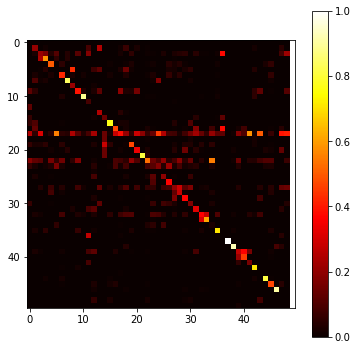

In [9]:
a = confusion_matrix(lr.predict(xTe), yTe)
plt.figure(figsize=(6,6))
plt.imshow(a/a.sum(axis=0), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [10]:
joblib.dump(lr, lr_fname)

['./Data/processed/lr_trained.pkl']

# Neural Networks

## Fully connected

In [6]:
model = Sequential([
        Dense(512, input_dim=900, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='softmax')
    ])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [7]:
history = model.fit(xTr, yTr_cat, epochs=50, batch_size=128, verbose=1)

Epoch 1/50
17522/17522 [==============================] - 0s - loss: 3.0277 - acc: 0.2322     
Epoch 2/50
17522/17522 [==============================] - 0s - loss: 2.0344 - acc: 0.4189     
Epoch 3/50
17522/17522 [==============================] - 0s - loss: 1.5424 - acc: 0.5242     
Epoch 4/50
17522/17522 [==============================] - 0s - loss: 1.2537 - acc: 0.5878     
Epoch 5/50
17522/17522 [==============================] - 0s - loss: 1.0747 - acc: 0.6284     
Epoch 6/50
17522/17522 [==============================] - 0s - loss: 0.9536 - acc: 0.6602     
Epoch 7/50
17522/17522 [==============================] - 0s - loss: 0.8686 - acc: 0.6826     
Epoch 8/50
17522/17522 [==============================] - 0s - loss: 0.8306 - acc: 0.6883     
Epoch 9/50
17522/17522 [==============================] - 0s - loss: 0.7620 - acc: 0.7059     
Epoch 10/50
17522/17522 [==============================] - 0s - loss: 0.7283 - acc: 0.7139     
Epoch 11/50
17522/17522 [========================

In [8]:
preds = model.predict(xTe)

In [9]:
(preds.argmax(axis=1) == yTe).mean()

0.78269801415202012

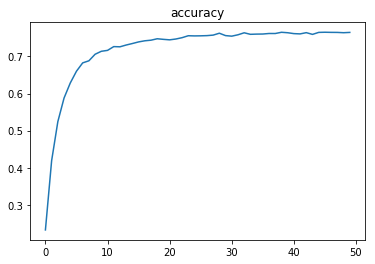

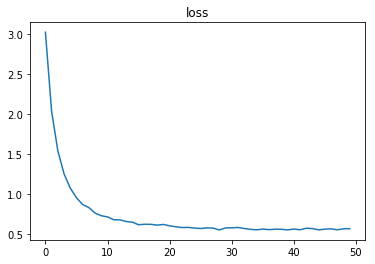

In [10]:
plt.plot(history.history['acc'])
plt.title('accuracy')
plt.show()
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

## ConvNet A

In [11]:
xTr_conv = xTr.reshape(-1, 3, 300, 1)
xTe_conv = xTe.reshape(-1, 3, 300, 1)

In [12]:
model = Sequential([
        Conv2D(128, (3,50), activation='relu', input_shape=(3,300,1), padding='same'),
        Conv2D(128, (3,30), activation='relu', padding='same'),
        Conv2D(128, (3,10), activation='relu', padding='same'),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='softmax')
    ])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [13]:
history = model.fit(xTr_conv, yTr_cat, epochs=10, batch_size=128, validation_data=(xTe_conv, yTe_cat))

Train on 17522 samples, validate on 4381 samples
Epoch 1/10
17522/17522 [==============================] - 57s - loss: 2.3634 - acc: 0.3675 - val_loss: 0.7551 - val_acc: 0.7092
Epoch 2/10
17522/17522 [==============================] - 58s - loss: 0.7860 - acc: 0.7192 - val_loss: 0.4221 - val_acc: 0.7774
Epoch 3/10
17522/17522 [==============================] - 59s - loss: 0.5329 - acc: 0.7699 - val_loss: 0.3746 - val_acc: 0.7809
Epoch 4/10
17522/17522 [==============================] - 60s - loss: 0.4417 - acc: 0.7925 - val_loss: 0.3425 - val_acc: 0.7797
Epoch 5/10
17522/17522 [==============================] - 61s - loss: 0.4042 - acc: 0.7878 - val_loss: 0.3239 - val_acc: 0.7834
Epoch 6/10
17522/17522 [==============================] - 62s - loss: 0.3739 - acc: 0.7968 - val_loss: 0.3286 - val_acc: 0.7852
Epoch 7/10
17522/17522 [==============================] - 61s - loss: 0.3583 - acc: 0.7991 - val_loss: 0.3204 - val_acc: 0.7802
Epoch 8/10
17522/17522 [==============================]

In [14]:
preds = model.predict(xTe_conv)
(preds.argmax(axis=1) == yTe).mean()

0.77790458799360873

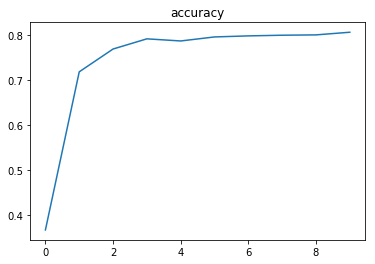

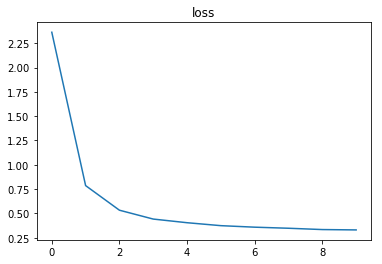

In [15]:
plt.plot(history.history['acc'])
plt.title('accuracy')
plt.show()
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

## Convnet B

In [16]:
yTr_bin = np.logical_or(yTr == 18, yTr == 33) + 0
yTe_bin = np.logical_or(yTe == 18, yTe == 33) + 0

In [21]:
model = Sequential([
        Conv2D(128, (3,50), activation='relu', input_shape=(3,300,1), padding='same'),
        Conv2D(128, (3,30), activation='relu', padding='same'),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(3,10)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [24]:
history = model.fit(xTr_conv, yTr_bin, epochs=2, batch_size=128, validation_data=(xTe_conv, yTe_bin))

Train on 17522 samples, validate on 4381 samples
Epoch 1/2
17522/17522 [==============================] - 43s - loss: 0.1022 - acc: 0.9396 - val_loss: 0.1067 - val_acc: 0.9283
Epoch 2/2
17522/17522 [==============================] - 44s - loss: 0.0959 - acc: 0.9409 - val_loss: 0.0991 - val_acc: 0.9299


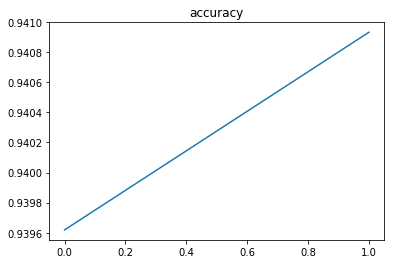

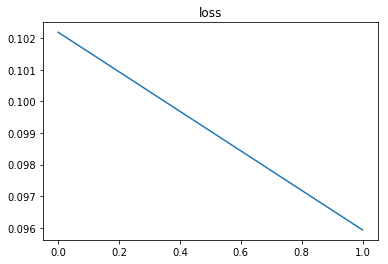

In [25]:
plt.plot(history.history['acc'])
plt.title('accuracy')
plt.show()
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()